## Project 2 - Web Scraping

Arkael Kernizan <br>
11/2/2024

The purpose of this program is to gather data about the Manchester City Football Club from FBref and answer 4 questions.

### Imports

In [4]:
import requests
import time
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
print('seaborn version:', sns.__version__)
print('matplotlib version:', matplotlib.__version__)

seaborn version: 0.13.2
matplotlib version: 3.9.2


### Main scraping function

- The function below is used grab the HTML of website. If the request is succesful it is returned, else the status error will print.

In [8]:
def get_website(url):
    response = requests.get(url)
    status = response.status_code
    
    if status == 200:
        return response.text
    else: 
        print(f'whoops, recieved status is: {status}')

## Question 1: What is the average amount of playing time substitute players have played in games this season?


First an HTML GET request is made to [FBref: Manchester City Page](https://fbref.com/en/squads/b8fd03ef/Manchester-City-Stats). The Playing Time table is scraped, collecting players' names, the number of games played as a substitute, and the minutes played as a substitute. The average substitute min per game is calculated.

In [11]:
# starting link to request HTML
url = 'https://fbref.com/en/squads/b8fd03ef/Manchester-City-Stats'
page = get_website(url)
# url HTML saved
soup = bs(page)

In [12]:
# scrape and store Playing Table from soup 
playingTimeStats = []
playingTimeTable = soup.find(class_ = 'stats_table', id = 'stats_playing_time_9').tbody

In [13]:
# for loop to iterate through Playing Time table
# grab player name, # of games, and sub mins played
for row in playingTimeTable.find_all('tr'):
    time.sleep(2)
    player = row.find(attrs = {'data-stat':'player', 'scope':'row'}).text
    subGames = row.find(attrs = {'data-stat':'games_subs'}).text
    subTime = row.find(attrs = {'data-stat':'minutes_per_sub'}).text
    playingTimeStats.append({'player': player, '# of games': subGames, 'minutes played': subTime})
substituteTime = pd.DataFrame(playingTimeStats)

In [14]:
# remove empty rows from DataFrame, convert columns to float
# can perform count as float
substituteTime = substituteTime[substituteTime['# of games'] != '0']    
substituteTime['# of games'] = substituteTime['# of games'].astype(float)
substituteTime['minutes played'] = substituteTime['minutes played'].astype(float)

In [15]:
numGamesPlayed = substituteTime['# of games'].sum()
numMinsPlayeed = substituteTime['minutes played'].sum()
minsPerGame = round(numMinsPlayeed/numGamesPlayed, 2)
minsPerGame

9.76

#### Answer: Based on collected data, a substitute player for Manchester City can expect to play for an average of *9.76* mins per game if they play.

## Question 2: With the current roster, from the years 2015-2024, which year did the team have the most goals?


Like the previous question, [FBref: Manchester City Page](https://fbref.com/en/squads/b8fd03ef/Manchester-City-Stats) is requested. The Standard Stats table is saved and scraped for the players' personal link. When concatenated with FBref base url, the player's links are created. These links contain individual stats from each player's career. From the player link, the goals and seasons they scored while playing for Manchester City are scraped from the page. These goals are stored in a Data Frame and grouped by the years they were scored.

In [19]:
url = 'https://fbref.com/en/squads/b8fd03ef/Manchester-City-Stats'
urlBase = 'https://fbref.com/'
page = get_website(url)
soup = bs(page)

playerLinks = []
standardTable = soup.find(id = 'stats_standard_9').tbody

# this for loop gets the player's personal links 
for row in standardTable.find_all('tr'):
    time.sleep(5)
    playerUrl = urlBase + row.find(attrs = {'data-stat': 'player'}).a['href']
    playerLinks.append(playerUrl)

In [20]:
playerLinks

['https://fbref.com//en/players/3bb7b8b4/Ederson',
 'https://fbref.com//en/players/1f44ac21/Erling-Haaland',
 'https://fbref.com//en/players/5ad50391/Josko-Gvardiol',
 'https://fbref.com//en/players/3eb22ec9/Bernardo-Silva',
 'https://fbref.com//en/players/79c0821a/Mateo-Kovacic',
 'https://fbref.com//en/players/89ac64a6/Manuel-Akanji',
 'https://fbref.com//en/players/31c69ef1/Ruben-Dias',
 'https://fbref.com//en/players/b57e066e/Rico-Lewis',
 'https://fbref.com//en/players/819b3158/Ilkay-Gundogan',
 'https://fbref.com//en/players/fe6e7156/Savio',
 'https://fbref.com//en/players/fffea3e5/Jeremy-Doku',
 'https://fbref.com//en/players/86dd77d1/Kyle-Walker',
 'https://fbref.com//en/players/e46012d4/Kevin-De-Bruyne',
 'https://fbref.com//en/players/b0b4fd3e/Jack-Grealish',
 'https://fbref.com//en/players/ed1e53f3/Phil-Foden',
 'https://fbref.com//en/players/5eecec3d/John-Stones',
 'https://fbref.com//en/players/e6af02e0/Matheus-Nunes',
 'https://fbref.com//en/players/eaeca114/Nathan-Ake',


### Individual player scraping function 
- The function will scrape the HTML from the Standard Stats table of a player's profile page
- The season and goals are collected and added to a list

In [22]:
def getPlayerStat(soup):
    playerList = []
    standardStatsTable = soup.find(class_ = 'stats_table', id= 'stats_standard_dom_lg').tbody

    for row in standardStatsTable.find_all('tr'):
        time.sleep(1)
        squad = row.find(attrs = {'data-stat':'team'}).text
        
        #check for  goals scored as a Man City player.
        if squad == 'Manchester City':
            season = row.find(attrs = {'data-stat':'year_id'}).text
            goals = row.find(attrs = {'data-stat':'goals'}).text
            playerList.append({'season': season, 'goals': goals})
    return playerList

In [23]:
# iterate through each player link, HTML request page, append scraped goals and season 
playerStats = []
for link in playerLinks:
    page = get_website(link)
    soup = bs(page)
    playerStats.append(getPlayerStat(soup))
    time.sleep(5)

In [24]:
# playerStats

In [25]:
# playerStat is a list nested in a list, need loop to iterate through player and then season
# append to new empty list, then convert to Data Frame 
cleanPlayerStats = []
for player in playerStats:
    for season in player:
            cleanPlayerStats.append(season)
dfPlayerStats = pd.DataFrame(cleanPlayerStats)

In [26]:
dfPlayerStats.head(10)

,season,goals
0,2017-2018,0
1,2018-2019,0
2,2019-2020,0
3,2020-2021,0
4,2021-2022,0
5,2022-2023,0
6,2023-2024,0
7,2024-2025,0
8,2022-2023,36
9,2023-2024,27


In [27]:
# some entries of 'goals' column are empty, fill empty with 0 then convert coluumns to int
# help from ChatGPT to fill empty rows with 0
dfPlayerStats['goals'] = pd.to_numeric(dfPlayerStats['goals'], errors='coerce').fillna(0).astype(int)
groupStats = dfPlayerStats.groupby('season', as_index = False)['goals'].sum()


In [28]:
groupStats

,season,goals
0,2015-2016,7
1,2016-2017,9
2,2017-2018,24
3,2018-2019,17
4,2019-2020,30
5,2020-2021,46
6,2021-2022,76
7,2022-2023,76
8,2023-2024,87
9,2024-2025,25


C:\Users\arkke\AppData\Local\Temp\ipykernel_11760\95024225.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'])


([<matplotlib.axis.YTick at 0x23f7f9a8560>,
 [Text(0, 0, '0'),
  Text(0, 10, '10'),
  Text(0, 20, '20'),
  Text(0, 30, '30'),
  Text(0, 40, '40'),
  Text(0, 50, '50'),
  Text(0, 60, '60'),
  Text(0, 70, '70'),
  Text(0, 80, '80'),
  Text(0, 90, '90')])

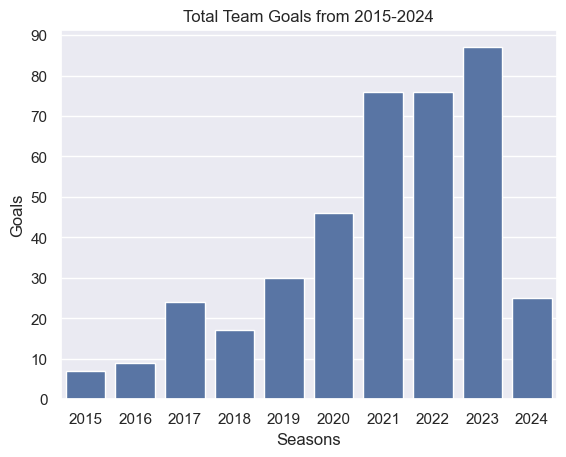

In [29]:
# seaborn to plot
sns.set(style = 'darkgrid')
g = sns.barplot(x = 'season', y = 'goals', data = groupStats)
plt.title("Total Team Goals from 2015-2024")
plt.xlabel('Seasons')
g.set_xticklabels(['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'])
plt.ylabel('Goals')
plt.yticks(np.arange(0, 100, 10))

#### Answer: The plot above shows Manchest City goals with the current roster from 2015 to the current season. In 2023 the current roster had the most goals with 87 goals. The 2022 & 2023 season were next highest, tied at 76 goals. The current season climbing with about 30% of the previous season's goals.

## Question 3: What positions make the most tackles and what third of the field do they occur in?

The below will scrape from [FBref: Manchester City Page](https://fbref.com/en/squads/b8fd03ef/Manchester-City-Stats). The Defense table will be collected. From there, position, total tackles, & tackles of each third are scraped and put in a Data Frame. The sum of tackles in each third is compared and the positions making those tackles are summed as well.

In [33]:
url = 'https://fbref.com/en/squads/b8fd03ef/Manchester-City-Stats'
page = get_website(url)
soup = bs(page)

In [34]:
# scraping Defense Action table from website
defense = []
defenseTable = soup.find(class_ = 'stats_table', id = 'stats_defense_9').tbody

# scraping player position, # of tackles, # of tackles made in defensive, middle, offensive third
for row in defenseTable.find_all('tr'):
    position = row.find(attrs = {'data-stat':'position'}).text
    tackles = row.find(attrs = {'data-stat':'tackles'}).text
    defThird = row.find(attrs = {'data-stat':'tackles_def_3rd'}).text
    midThird = row.find(attrs = {'data-stat':'tackles_mid_3rd'}).text
    attThird = row.find(attrs = {'data-stat':'tackles_att_3rd'}).text
    
    defense.append({'position': position, 'total tackles': tackles, 'defensive 3rd': defThird, 'middle 3rd': midThird, 'attacking 3rd': attThird})
tacklesMade = pd.DataFrame(defense)


In [35]:
# convert table to into integers for count
tacklesMade['total tackles'] = tacklesMade['total tackles'].astype(int)
tacklesMade['defensive 3rd'] = tacklesMade['defensive 3rd'].astype(int)
tacklesMade['middle 3rd'] = tacklesMade['middle 3rd'].astype(int)
tacklesMade['attacking 3rd'] = tacklesMade['attacking 3rd'].astype(int)

In [36]:
tacklesMade.head()

,position,total tackles,defensive 3rd,middle 3rd,attacking 3rd
0,GK,0,0,0,0
1,FW,2,0,1,1
2,DF,18,9,5,4
3,"MF,FW",8,0,3,5
4,MF,22,5,12,5


In [37]:
# this removes secondary positions of players that have 2
tacklesMade['position'] = tacklesMade['position'].str.split(',').str[0]
tacklesMade.head()

,position,total tackles,defensive 3rd,middle 3rd,attacking 3rd
0,GK,0,0,0,0
1,FW,2,0,1,1
2,DF,18,9,5,4
3,MF,8,0,3,5
4,MF,22,5,12,5


In [38]:
# sum tackles for each third of field, group by position
positionTackles = tacklesMade.groupby('position').sum()
positionTackles

,total tackles,defensive 3rd,middle 3rd,attacking 3rd
position,,,,
DF,42,20,14,8
FW,27,8,7,12
GK,0,0,0,0
MF,63,20,29,14


In [39]:
# most tackles by position
mostTacklesPosition = positionTackles.idxmax()
mostTacklesPosition

total tackles    MF
defensive 3rd    DF
middle 3rd       MF
attacking 3rd    MF
dtype: object

In [40]:
print(f'defensive tackles: {tacklesMade['defensive 3rd'].sum()}')
print(f'middle tackles: {tacklesMade['middle 3rd'].sum()}')
print(f'attacking tackles: {tacklesMade['attacking 3rd'].sum()}')

defensive tackles: 48
middle tackles: 50
attacking tackles: 34


#### Answer: The data shows a majority of tackles happen in the middle third of the field with 50 tackles this 2024 season. The defensive third has the second most tackles with 48 this season. Mid fielders make the most tackles for the team overall.

## Question 4: How many players current goals are higher than their expected goals? What are the players names?


Continuing with the same link, the Standard Stats table is scraped for player name, number of goals this season, and expected goals this season. Then the Data Frame holding this data is cleaned 

In [44]:
expGoals = []
standardTable = soup.find(class_ = 'stats_table').tbody
# standard_table

for row in standardTable.find_all('tr'):
    player = row.find(attrs = {'data-stat':'player'}).text
    numGoals = row.find(attrs = {'data-stat':'goals'}).text
    xptGoals = row.find(attrs = {'data-stat':'xg'}).text
    
    expGoals.append({'player': player, 'goals': numGoals, 'expected goals': xptGoals})
goalCompare = pd.DataFrame(expGoals)

In [45]:
# clean DataFrame for empty rows and convert to numeric
goalCompare= goalCompare[goalCompare['goals'] != '']
goalCompare['goals'] = goalCompare['goals'].astype(int)
goalCompare['expected goals'] = goalCompare['expected goals'].astype(float)
goalCompare.head(10)

,player,goals,expected goals
0,Ederson,0,0.0
1,Erling Haaland,11,9.7
2,Joško Gvardiol,3,0.6
3,Bernardo Silva,0,1.4
4,Mateo Kovačić,3,0.9
5,Manuel Akanji,0,0.1
6,Rúben Dias,0,0.6
7,Rico Lewis,0,0.7
8,İlkay Gündoğan,0,1.3
9,Sávio,0,1.1


In [46]:
# iterate through Dataframe and compare goals scored to excpected goals, if the player is outperforming the expected add to list 
aboveExpected = []
for row, col in goalCompare.iterrows():
    if col['goals'] > col ['expected goals']:
        aboveExpected.append(col.tolist())
aE = pd.DataFrame(aboveExpected)
aE.rename(columns = {0: 'players', 1: 'goals scored', 2: 'expected goals'}, inplace = True)
aE

,players,goals scored,expected goals
0,Erling Haaland,11,9.7
1,Joško Gvardiol,3,0.6
2,Mateo Kovačić,3,0.9
3,Jeremy Doku,1,0.4
4,John Stones,2,0.4


Text(0, 0.5, 'Goals')

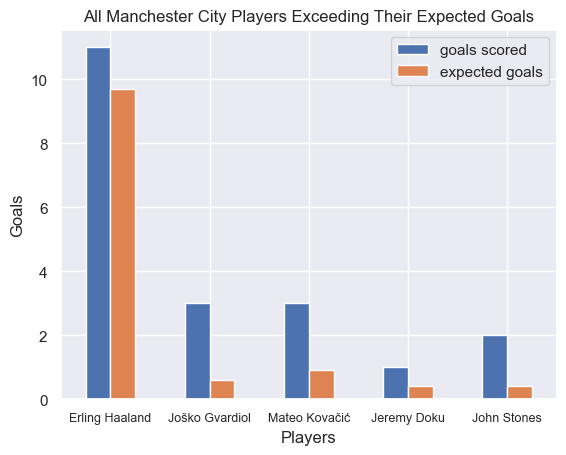

In [47]:
# plot data
sns.set()
aE.plot(kind = 'bar')

plt.title("All Manchester City Players Exceeding Their Expected Goals")
plt.xlabel('Players', fontsize = 12)
plt.xticks(range(len(aE)), labels = aE['players'], rotation = 0, fontsize = 9)
plt.ylabel('Goals', fontsize = 12)

#### Answer: The plot above shows that there are five players who are out performing their current expected goals this season. Josko Gvardiol has the best ratio between scored and expected, while Erling Haaland is the current goal leader.